# Лабораторная работа №4

# Логические методы классификации

In [27]:
import numpy as np
import pandas as pd

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

data_source = 'mine-dataset.data.csv'
d = pd.read_table(data_source, delimiter=',', keep_default_na=False,
                  header=None, names=['voltage', 'high', 'soil', 'answer'])
dX = d.iloc[:, 0:3]
dy = d['answer']
print(dX.head())
print(dy.head())

    voltage      high  soil
0  0.338157  0.000000   0.0
1  0.320241  0.181818   0.0
2  0.287009  0.272727   0.0
3  0.256284  0.454545   0.0
4  0.262840  0.545455   0.0
0    NULL
1    NULL
2    NULL
3    NULL
4    NULL
Name: answer, dtype: object


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
    train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5,
                              random_state=21,
                              max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.4019607843137255


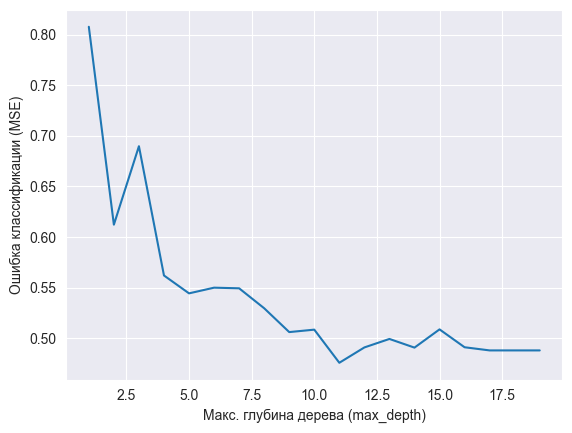

Оптимальные значения max_depth:  [11]


In [29]:
from sklearn.model_selection import cross_val_score

# Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d,
                                  random_state=21,
                                  max_features=2)
    scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

In [30]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,3) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(dX, dy)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

# Генерируем графическое представление лучшего дерева (сохранится в файле)
tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file='mines_tree.dot',
                     filled=True, rounded=True)

Fitting 10 folds for each of 38 candidates, totalling 380 fits


Лучшее сочетание параметров:  {'max_depth': 13, 'max_features': 1}
Лучшие баллы cross validation:  0.5556149732620321


Оптимальное дерево решений


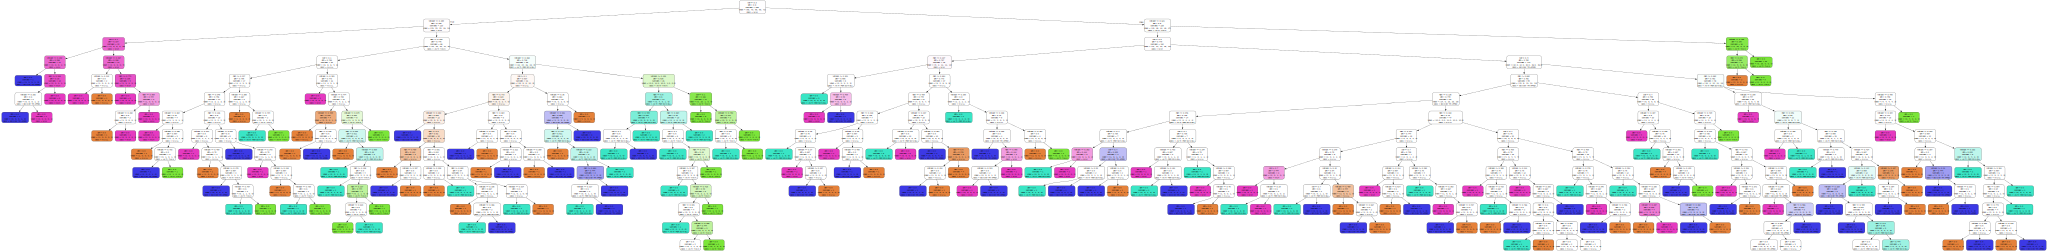

In [31]:
import graphviz
dot_data = tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file=None,
                     filled=True, rounded=True)
graph = graphviz.Source(dot_data)
open('mines_tree.svg', 'w').write(graph._repr_image_svg_xml())
print('Оптимальное дерево решений')
graph

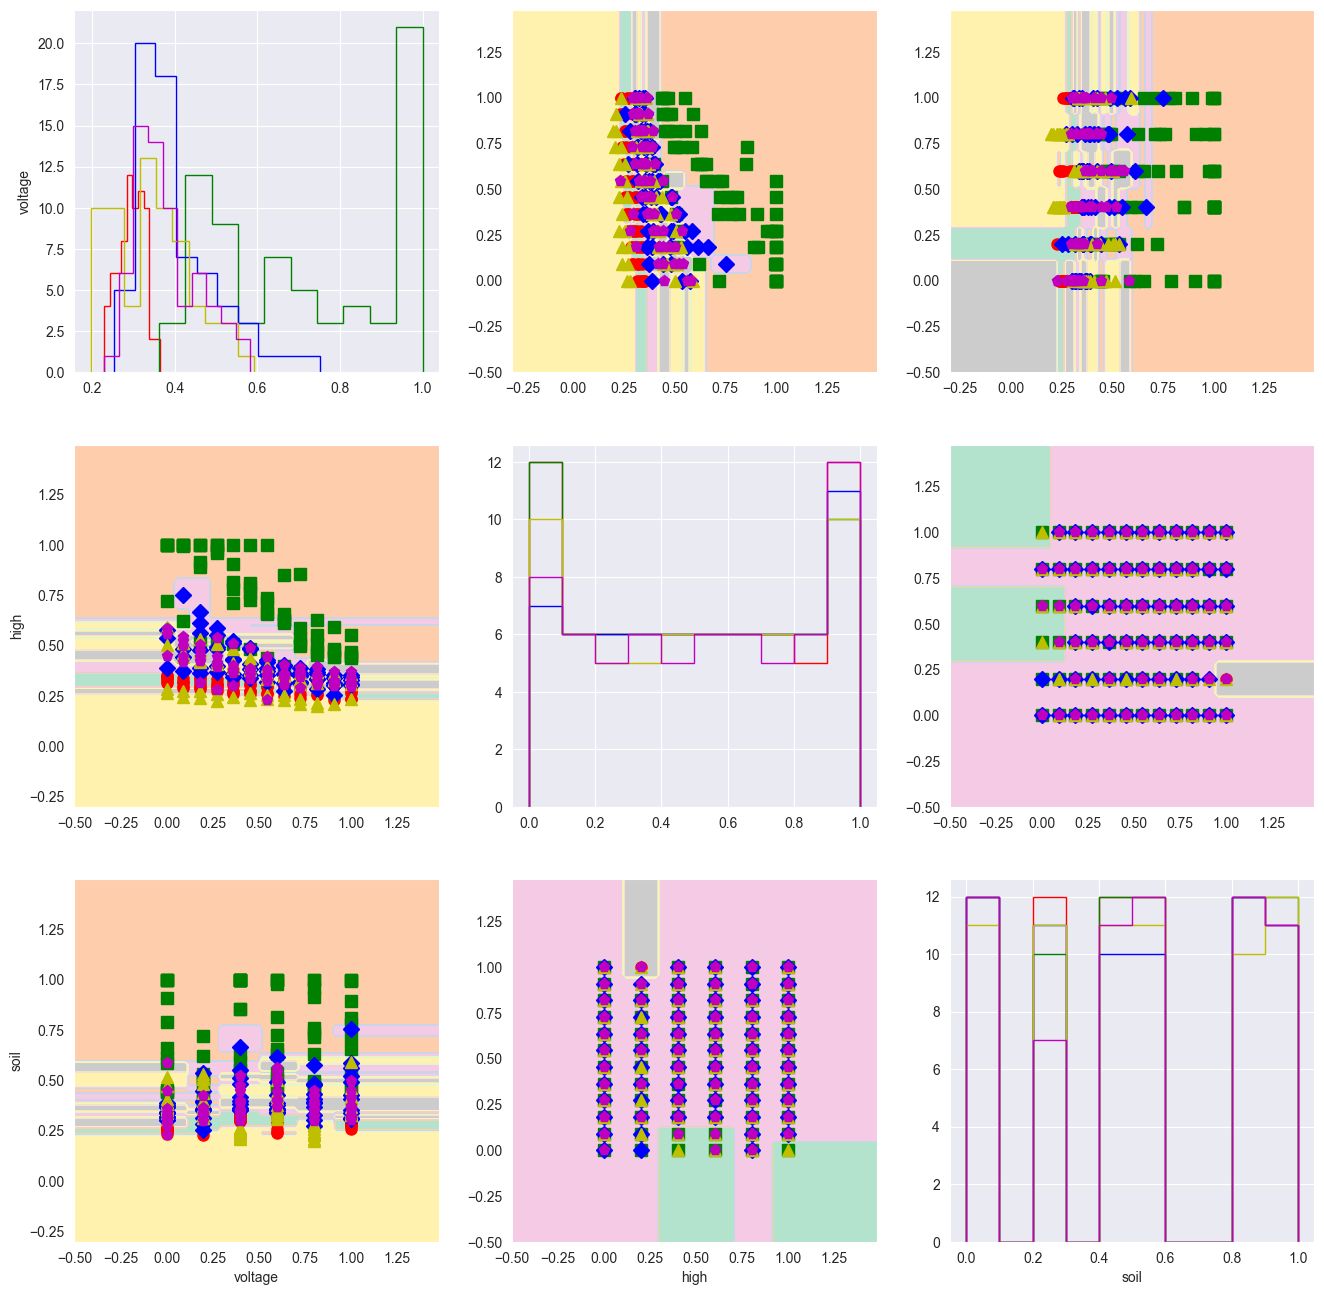

In [32]:
plot_markers = ['ro', 'gs', 'bD', 'y^', 'mp']
answers = dy.unique()
labels = dX.columns.values
# Подграфики для каждой пары признаков
f, places = plt.subplots(3, 3, figsize=(16, 16))

fmin = dX.min().values-0.5
fmax = dX.max().values+0.5
plot_step = 0.02

# Обходим все subplot
for i in range(0,3):
    for j in range(0,3):

        # Строим решающие границы
        if i != j:
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step, dtype=float),
                               np.arange(fmin[j], fmax[j], plot_step, dtype=float))
            model = DecisionTreeClassifier(max_depth=13, random_state=21, max_features=1)
            model.fit(dX.iloc[:, [i,j]].values, dy.values)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p==answers[0]] = 0
            p[p==answers[1]] = 1
            p[p==answers[2]] = 2
            p[p==answers[3]] = 3
            p[p==answers[4]] = 4
            p=p.astype('int32')
            places[i,j].contourf(xx, yy, p, cmap=plt.cm.Pastel2)

        # Обход всех классов (Вывод обучающей выборки)
        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])
            if i==j:
                places[i, j].hist(dX.iloc[idx].iloc[:,i],
                                  color=plot_markers[id_answer][0],
                                  histtype = 'step')
            else:
                places[i, j].plot(dX.iloc[idx].iloc[:,i], dX.iloc[idx].iloc[:,j],
                                  plot_markers[id_answer],
                                  label=answers[id_answer], markersize=8)

        # Печать названия осей
        if j==0:
          places[i, j].set_ylabel(labels[i])

        if i==2:
          places[i, j].set_xlabel(labels[j])